In [ ]:
### Some parts of the code depend on Siqi Wu's code: https://github.com/avalanchesiqi/networked-popularity
### In order to run the code, please clone Siqi Wu's repo and put this file in the root directory.
### Remember to download all data from https://drive.google.com/drive/folders/19R3_2hRMVqlMGELZm47ruk8D9kqJvAmL?usp=sharing
### And put all data to the data folder.

### Author: Yutian Zhao
### Reference from: Siqi Wu

<h1> Video Bridges </h1>

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
import sys, os, platform, pickle, json, time
from datetime import datetime, timedelta
import numpy as np
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import math
import scipy as sp
import scipy.stats
from collections import defaultdict 

from utils.data_loader import DataLoader
from utils.plot import ColorPalette, concise_fmt, hide_spines, stackedBarPlot
data_prefix = 'data/' # ../

# from powerlaw import Fit, plot_ccdf

import matplotlib as mpl
if platform.system() == 'Linux':
    mpl.use('Agg')  # no UI backend

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
mpl.rcParams['lines.linewidth'] = 1

T = 63

In [ ]:
if not os.path.exists(os.path.join(data_prefix, "test_strong_bridges.pkl")):
    test = nx.strongly_connected_components(graph_lst[0])
    lscc_test = max(test, key=len)
    test_subgraph = graph_lst[0].subgraph(lscc_test, )
    with open(os.path.join(data_prefix, "test_strong_bridges.pkl"), 'wb') as fout:
        pickle.dump(test_subgraph.copy(), fout)
else:
    with open(os.path.join(data_prefix, "test_strong_bridges.pkl"), 'rb') as fin:
        test_subgraph = pickle.load(fin)

In [4]:
data_loader = DataLoader()
data_loader.load_embed_content_dict()
# data_loader.cwd
embed_view_dict = data_loader.embed_view_dict
embed_avg_view_dict = data_loader.embed_avg_view_dict
num_videos = data_loader.num_videos
embed_title_dict = data_loader.embed_title_dict

>>> Daily view data has been loaded!


In [5]:
### contrust network graph for each day
if not os.path.exists(os.path.join(data_prefix, "video_network.pkl")):
    graph_lst = []
    for i in edges:
        G = nx.DiGraph()
        G.add_edges_from(i)
        graph_lst.append(G)
        
    with open(os.path.join(data_prefix, "video_network.pkl"), 'wb') as fout:
        pickle.dump(graph_lst, fout)
else:
    with open(os.path.join(data_prefix, "video_network.pkl"), 'rb') as fin:
        graph_lst = pickle.load(fin)

In [6]:
scc_list = [nx.strongly_connected_components(G) for G in graph_lst]
lscc_list = [max(scc, key=len) for scc in scc_list]
lwcc_list = [max(nx.weakly_connected_components(G), key=len) for G in graph_lst]

In [7]:
lscc_subgraph_list = [graph_lst[i].subgraph(lscc_list[i]) for i in range(T)]

In [8]:
# if not os.path.exists(os.path.join(data_prefix, "lwcc_subgraph_list_15.pkl")):
    
#     with open(os.path.join(data_prefix, "lwcc_subgraph_list_15.pkl"), 'wb') as fout:
#         pickle.dump(lwcc_subgraph_list, fout)
# else:
#     with open(os.path.join(data_prefix, "lwcc_subgraph_list_15.pkl"), 'rb') as fin:
#         lwcc_subgraph_list = pickle.load(fin)
lwcc_subgraph_list = [(graph_lst[i].subgraph(lwcc_list[i])) for i in range(T)]

In [ ]:
test_graph_1 = nx.DiGraph()
test_graph_1.add_edges_from([[0, 1], [1, 2], [2, 0], [2, 3], [3, 4], [4, 5], [5, 3]])
test_graph_2 = nx.DiGraph()
test_graph_2.add_edges_from(test_graph_1.edges)
test_graph_2.add_edges_from([[1, 0], [5, 4], [3, 2]])
test_graph_3 = nx.DiGraph()
test_graph_3.add_edges_from(test_graph_2.edges)
test_graph_3.add_edges_from([[4, 0], [1, 5]])

In [ ]:
nx.draw_networkx(test_graph_1, pos=nx.planar_layout(test_graph_2), with_labels=True)

In [ ]:
nx.draw_networkx(test_graph_2, pos=nx.planar_layout(test_graph_2), with_labels=True)

In [ ]:
nx.draw_networkx(test_graph_3, pos=nx.planar_layout(test_graph_3), with_labels=True)

In [ ]:
subgraphs = [test_graph_2.subgraph(c) for c in nx.strongly_connected_components(test_graph_2)]
for i in range(len(subgraphs)):
    plt.subplot(len(subgraphs),1,i+1)
    nx.draw_networkx(subgraphs[i], pos=nx.planar_layout(test_graph_2), with_labels=True)

plt.show()

In [ ]:
tree_edges, back_edges, forward_edges, cross_edges = dfs_edges(0, test_graph_3)
print(forward_edges.items())
print(cross_edges.items())
print(back_edges.items())
print(tree_edges)

In [9]:
def dfs_edges(v, graph):
    # parent = {}
    start = defaultdict(int)
#     visited = defaultdict(bool)
    end = defaultdict(int)
    # entering u
    forward_edges = defaultdict(list)
    back_edges = defaultdict(list)
    cross_edges = defaultdict(list)
    tree_edges = []
    t = 0
#     print("entering dfs edges")

#     def dfs(v, graph, parent=None):
#         nonlocal t
#         t += 1
#         start[v] = t
#         if parent is not None:
#             tree_edges.append((parent, v))
#         for n in graph.successors(v):
#             if start[n] == 0:  # not visited
#                 dfs(n, graph, parent=v)
#             elif end[n] == 0:
#                 back_edges[n].append(v)
#             elif start[v] < start[n]:
#                 forward_edges[n].append(v)
#             else:
#                 cross_edges[n].append(v)
#         t += 1
#         end[v] = t
        
    def dfs(v, graph):
        nonlocal t
        stack = []
        stack.append((v, None)) # (v, parent)

        while (len(stack)):
            t += 1
            v, parent = stack[-1]
            if start[v] > 0 and end[v] == 0:
                end[v] = t
                stack.pop()
            elif start[v] > 0 and end[v] > 0:
                forward_edges[v].append(parent)
                stack.pop()
            else:
                start[v] = t
                if parent is not None:
                    tree_edges.append((parent, v))
#                 for n in sorted(graph.successors(v), reverse=True):
                for n in graph.successors(v):
                    if start[n] == 0:  # not visited
                        stack.append((n, v))
                    elif end[n] == 0:
                        back_edges[n].append(v)
                    elif start[v] < start[n]:
                        forward_edges[n].append(v)
                    else:
                        cross_edges[n].append(v)
            
    dfs(v, graph)
    
    return tree_edges, back_edges, forward_edges, cross_edges

def dominator_tree(v, graph):
    dt = nx.DiGraph()
#     print("entering dominator_tree")
    idoms = nx.immediate_dominators(graph, v)
    for k, v in idoms.items():
        if k != v:
            dt.add_edge(v, k)
    return dt

def dfs_order(v, graph, ):
    start = defaultdict(int)
    end = defaultdict(int)
    t = 0
#     print("entering dfs order")
    
#     def dfs(v, graph,):
#         nonlocal t
#         t += 1
#         start[v] = t
#         for n in graph.successors(v):
#             if start[n] == 0:  # not visited
#                 dfs(n, graph, )
#         t += 1
#         end[v] = t
        
    def dfs(v, graph):
        nonlocal t
        stack = []
        stack.append((v, None)) # (v, parent)

        while (len(stack)):
            t += 1
            v, parent = stack[-1]
            if start[v] > 0 and end[v] == 0:
                end[v] = t
                stack.pop()
            elif start[v] > 0 and end[v] > 0:
                stack.pop()
            else:
                start[v] = t
#                 for n in sorted(graph.successors(v), reverse=True):
                for n in graph.successors(v):
                    if start[n] == 0:  # not visited
                        stack.append((n, v))
        
    dfs(v, graph)
    
    return start, end

def edge_dominators(v, graph):    
    edge_dominator = set()
    tree_edges, back_edges, forward_edges, cross_edges = dfs_edges(v, graph)
#     print("finish dfs edges")
    dt = dominator_tree(v, graph)
#     print("finish dominator_tree")
    start, end = dfs_order(v, dt)
#     print("finish dfs_order")
    for e in tree_edges:
        if len(forward_edges[e[1]])==0 and len(cross_edges[e[1]])==0:
            flag = True
            for i in back_edges[e[1]]:  # for every back edge, e_1 dominate i
                if not ((start[e[1]] < start[i]) and (end[i] < end[e[1]])):
                    flag = False
            if flag:
                edge_dominator.add(e)
    return edge_dominator

def strong_edges(v, graph):
#     print("here")
    de = edge_dominators(v, graph)
    for v, u in edge_dominators(v, graph.reverse()):
        de.add((u, v))
    return de

In [10]:
### LSCC
## list of strong edges
def choose_node(scc):
    v = scc.pop()
    scc.add(v)
    return v

node_list = [choose_node(scc) for scc in lscc_list]

In [11]:
if not os.path.exists(os.path.join(data_prefix, "se_list_video_15.pkl")):
    se_list = [] 
    for i in range(T):
        se = strong_edges(node_list[i], lscc_subgraph_list[i])
        print("finish se ", i)
        se_list.append(se)
    print("done") 
    
    with open(os.path.join(data_prefix, "se_list_video_15.pkl"), 'wb') as fout:
        pickle.dump(se_list, fout)
else:
    with open(os.path.join(data_prefix, "se_list_video_15.pkl"), 'rb') as fin:
        se_list = pickle.load(fin)

se_len_list = [len(i) for i in se_list]

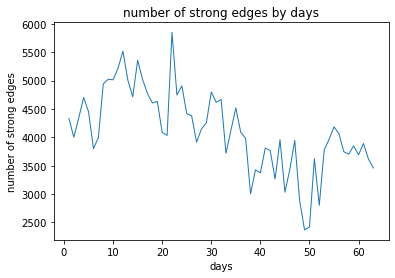

In [13]:
## length of se_list
plt.plot([*range(1,64)], se_len_list)
plt.title("number of strong edges by days")
plt.xlabel("days")
plt.ylabel("number of strong edges")
plt.show();

In [66]:
## appear times
def appear_times(se_list):
    se_times = defaultdict(int)
    for i in range(T):
        for j in se_list[i]:
            se_times[j] += 1
    se_times_sorted = sorted(se_times.items(), key=lambda x: x[1], reverse=True)
    return se_times, se_times_sorted

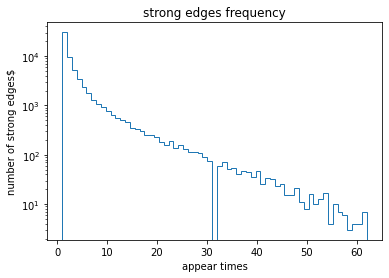

In [67]:
se_times, se_times_sorted = appear_times(se_list)
plt.hist(se_times.values(), bins=63, density=False, log=True, histtype="step")
plt.title("strong edges frequency")
plt.ylabel('number of strong edges$')
plt.xlabel('appear times')
plt.show();

In [12]:
if not os.path.exists(os.path.join(data_prefix, "bridge_list_15.pkl")):
    bridge_list = []
    for i in tqdm(range(T)):
        b_lst = []
        bridges = nx.bridges(lwcc_subgraph_list[i].to_undirected())
        
        print("finish be ", i)
        for b in tqdm(bridges):
            b_lst.append(b)
        bridge_list.append(b_lst)
        print("finish b ", len(b_lst))
        
    with open(os.path.join(data_prefix, "bridge_list_15.pkl"), 'wb') as fout:
        pickle.dump(bridge_list, fout)
else:
    with open(os.path.join(data_prefix, "bridge_list_15.pkl"), 'rb') as fin:
        bridge_list = pickle.load(fin)
        
bridge_len_list = [len(b) for b in bridge_list]

In [10]:
# modified Shannon diversity
def msd(lst):
    s = sum(lst)
    return sum([(i/s)*math.log(i/s, 2) for i in lst])/math.log(s, 2)
    

In [42]:
## edge importance by how much component it breaks apart and how many nodes left out
def edge_score(e_list, subgraph_list, mode):
    score_list = []
    for i, subgraph in enumerate(subgraph_list):
        if i in [0]: # , 15, 30, 45]:
            sg = subgraph.copy()

            scores = []
            print(i)
            for se in tqdm(e_list[i]):


                if mode=='weak':
                    if sg.has_edge(*se):
                        src = se[0]
                        tgt = se[1]
                    else:
                        src = se[1]
                        tgt = se[0]
                    sg.remove_edge(src, tgt)                       
                    components = [len(c) for c in nx.weakly_connected_components(sg)]
                    sg.add_edge(src, tgt)

                else:
                    sg.remove_edge(*se)
                    components = [len(c) for c in nx.strongly_connected_components(sg)]
                    sg.add_edge(*se)

                num_lost = sum(components) - max(components)
                len_com = len(components)

                if  mode=='weak':
                    if len_com == 1:
                        if not (sg.has_edge(*se) and sg.has_edge(se[1], se[0])):
                            print("graph ", i, " has ", len(components), " components without ", se)
                            return None
                    elif  len(components) > 2:
                        print("graph ", i, " has ", len_com, " components without ", se)
                        return None
                    else:
                        score = [(src, tgt), msd(components), num_lost, len_com, ]
                        scores.append(score)
                else:
                    score = [se, msd(components), num_lost, len_com, ] # in out
                    scores.append(score)

            score_list.append(scores)
    
    return score_list

bridge_score_list = edge_score(bridge_list, lwcc_subgraph_list, 'weak') 
se_score_list = edge_score(se_list, lscc_subgraph_list, 'strong')

  0%|                                                                                 | 1/1231 [00:00<04:13,  4.85it/s]

0


  0%|                                                                                 | 1/4331 [00:00<08:33,  8.43it/s]

0


100%|██████████████████████████████████████████████████████████████████████████████| 4331/4331 [09:10<00:00,  7.87it/s]


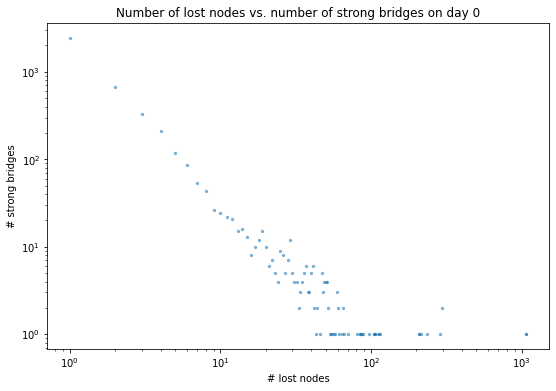

In [60]:
plt.figure(figsize=(9,6))
num_lost_se_c = Counter([i[2] for i in se_score_list[0]])
num_lost_se = list(zip(*(num_lost_se_c.items())))
plt.scatter(num_lost_se[0], num_lost_se[1], s=5, marker='o', alpha=0.5)
plt.title("Number of lost nodes vs. number of strong bridges on day 0")
plt.xlabel("# lost nodes")
plt.ylabel("# strong bridges")
plt.xscale('log')
plt.yscale('log')
plt.show();

In [53]:
sorted(se_score_list[0], key= lambda x : -x[1], reverse=True)

[[(55792, 18414), -0.037322833820115926, 1076, 50],
 [(18414, 41474), -0.03729627768020318, 1075, 51],
 [(29576, 31487), -0.014740302808523365, 298, 32],
 [(43525, 29576), -0.014274250223034912, 298, 26],
 [(31487, 49437), -0.013963082856161706, 287, 27],
 [(27875, 4483), -0.013317806406180988, 214, 32],
 [(4483, 48158), -0.013031406672597052, 209, 32],
 [(48158, 31283), -0.013008439836806818, 208, 33],
 [(49437, 16259), -0.010756037826716745, 237, 18],
 [(54819, 12017), -0.006763900005497905, 97, 29],
 [(1431, 59037), -0.006697431020426439, 114, 11],
 [(59037, 28159), -0.00661205438054541, 113, 10],
 [(28159, 22352), -0.006526677104235698, 112, 9],
 [(50766, 49593), -0.0062423560495932385, 107, 13],
 [(36407, 52714), -0.006196305981413125, 88, 29],
 [(49593, 32987), -0.0061569749557530955, 106, 12],
 [(52714, 51214), -0.006110912810491575, 87, 28],
 [(32987, 46937), -0.0060829093169457666, 105, 12],
 [(51214, 34685), -0.006047586143278062, 86, 28],
 [(46937, 10343), -0.005997526950992

12939

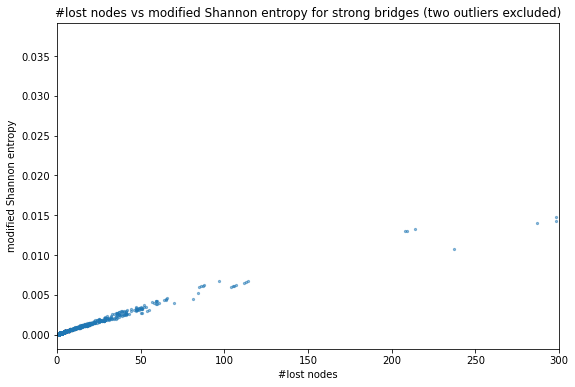

In [72]:
plt.figure(figsize=(9,6))
plt.scatter([i[2] for i in se_score_list[0]], [-i[1] for i in se_score_list[0]], s=5, marker='o', alpha=0.5)
# plt.xscale('log')
# plt.title("Indegree distribution")
plt.xlim(0, 300)
plt.title("#lost nodes vs modified Shannon entropy for strong bridges (two outliers excluded)")
plt.xlabel("#lost nodes")
plt.ylabel('modified Shannon entropy')
# plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

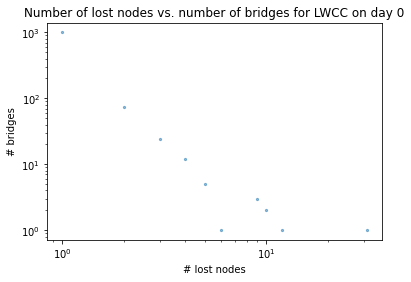

In [75]:
# plt.figure(figsize=(9,6))
num_lost_be_c = Counter([i[2] for i in bridge_score_list[0]])
num_lost_be = list(zip(*(num_lost_be_c.items())))
plt.scatter(num_lost_be[0], num_lost_be[1], s=5, marker='o', alpha=0.5)
plt.title("Number of lost nodes vs. number of bridges for LWCC on day 0")
plt.xlabel("# lost nodes")
plt.ylabel("# bridges")
plt.xscale('log')
plt.yscale('log')
plt.show();

In [68]:
sorted(bridge_score_list[0], key= lambda x : x[2], reverse=True)

[[(10823, 40985), -0.000401967666046182, 31, 2],
 [(50331, 54139), -0.00017283748841591216, 12, 2],
 [(47051, 27537), -0.00014679045324369588, 10, 2],
 [(26560, 32890), -0.00014679045324369588, 10, 2],
 [(23947, 2469), -0.00013354644208738963, 9, 2],
 [(24181, 14551), -0.00013354644208738963, 9, 2],
 [(58050, 40167), -0.00013354644208738963, 9, 2],
 [(16654, 5475), -9.271258186809265e-05, 6, 2],
 [(894, 26649), -7.864002833740959e-05, 5, 2],
 [(59301, 26099), -7.864002833740959e-05, 5, 2],
 [(48549, 20836), -7.864002833740959e-05, 5, 2],
 [(34003, 48273), -7.864002833740959e-05, 5, 2],
 [(11360, 24248), -7.864002833740959e-05, 5, 2],
 [(54230, 4922), -6.426275116431708e-05, 4, 2],
 [(10607, 1646), -6.426275116431708e-05, 4, 2],
 [(133, 15479), -6.426275116431708e-05, 4, 2],
 [(28946, 3716), -6.426275116431708e-05, 4, 2],
 [(57514, 48511), -6.426275116431708e-05, 4, 2],
 [(35721, 5896), -6.426275116431708e-05, 4, 2],
 [(33329, 24522), -6.426275116431708e-05, 4, 2],
 [(57797, 52813), -6.

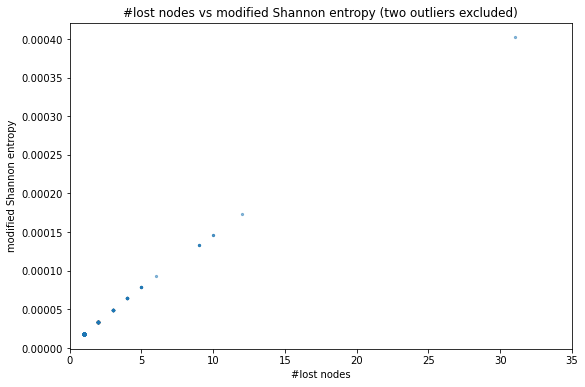

In [74]:
plt.figure(figsize=(9,6))
plt.scatter([i[2] for i in bridge_score_list[0]], [-i[1] for i in bridge_score_list[0]], s=5, marker='o', alpha=0.5)
# plt.xscale('log')
# plt.title("Indegree distribution")
plt.xlim(0, 35)
plt.title("#lost nodes vs modified Shannon entropy (two outliers excluded)")
plt.xlabel("#lost nodes")
plt.ylabel('modified Shannon entropy')
# plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.show();

In [ ]:
# [(55792, 18414), -0.037322833820115926, 1076, 50],
#  [(18414, 41474), -0.03729627768020318, 1075, 51]

In [79]:
day_0_lscc = lscc_subgraph_list[0].copy()
day_0_lscc_r = day_0_lscc.reverse()

In [107]:
predecessors = nx.dfs_successors(day_0_lscc_r, source=18414, depth_limit=1)
successors = nx.dfs_successors(day_0_lscc, source=18414, depth_limit=1)
nodes = set()
for v in successors.values():
    nodes.update(v)
for v in predecessors.values():
    nodes.update(v)
nodes.add(18414)
print(len(nodes))

13


In [108]:
se_subgraph = lscc_subgraph_list[0].subgraph(nodes)

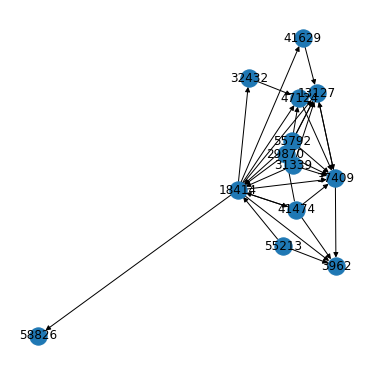

In [109]:
plt.figure(figsize=(5, 5))
nx.draw(se_subgraph, with_labels=True)

In [22]:
## lost nodes if bridge is deleted
def lost_nodes(e_list, subgraph_list, graph_lst, mode):
    avg_ind_list = []
    avg_view_list = []
#     for i, subgraph in enumerate(subgraph_list):
    candidates = [0] # , 15, 30, 45]:
    for i in candidates:
        sg = subgraph_list[i].copy()

        avg_ind = []
        avg_view = []
        print(i)
        for se in tqdm(e_list[i]):


            if mode=='weak':
                if sg.has_edge(*se):
                    src = se[0]
                    tgt = se[1]
                else:
                    src = se[1]
                    tgt = se[0]
                sg.remove_edge(src, tgt)                       
                components = sorted(nx.weakly_connected_components(sg), key=len)
                sg.add_edge(src, tgt)

            else:
                sg.remove_edge(*se)
                components = sorted(nx.strongly_connected_components(sg), key=len)
                sg.add_edge(*se)

            count = 0
            view_sum = 0
            indegree_sum = 0
            for c in components[:-1]:
                for v in c:
                    count += 1
                    view_sum += embed_avg_view_dict[v]
                    indegree_sum += graph_lst[i].in_degree(v)
            if count == 0:
                if not (sg.has_edge(*se) and sg.has_edge(se[1], se[0])):
                            print("graph: ", i, " has ", [len(component) for component in components], " components without ", se)
                            return None
            else:
                avg_ind.append(indegree_sum/count)
                avg_view.append(view_sum/count)        

        avg_ind_list.append(avg_ind)
        avg_view_list.append(avg_view)
    
    return avg_ind_list, avg_view_list

w_avg_ind_list, w_avg_view_list = lost_nodes(bridge_list, lwcc_subgraph_list, graph_lst, 'weak') 
s_avg_ind_list, s_avg_view_list = lost_nodes(se_list, lscc_subgraph_list, graph_lst, 'strong')

  0%|                                                                                 | 1/1231 [00:00<03:49,  5.36it/s]

0


  0%|                                                                                 | 1/4331 [00:00<07:42,  9.37it/s]

0


100%|██████████████████████████████████████████████████████████████████████████████| 4331/4331 [07:00<00:00, 10.29it/s]


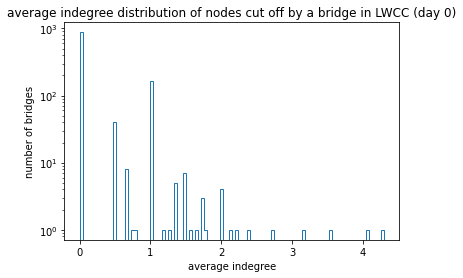

In [44]:
plt.hist(w_avg_ind_list[0], bins=100, density=False, log=True, histtype="step")
plt.title("average indegree distribution of nodes cut off by a bridge in LWCC (day 0)")
plt.ylabel('number of bridges')
plt.xlabel('average indegree')
plt.show();
    

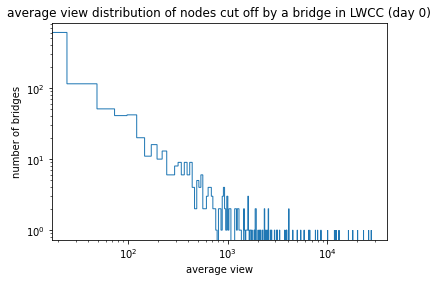

In [38]:
plt.hist(w_avg_view_list[0], bins=len(w_avg_ind_list[0]), density=False, log=True, histtype="step")
plt.title("average view distribution of nodes cut off by a bridge in LWCC (day 0)")
plt.ylabel('number of bridges')
plt.xlabel('average view')
plt.xscale('log')
plt.show();

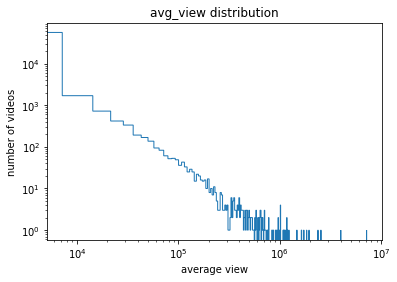

In [37]:
plt.hist(embed_avg_view_dict.values(), bins=1000, density=False, log=True, histtype="step")
plt.title("avg_view distribution")
plt.xscale('log')
plt.ylabel('number of videos')
plt.xlabel('average view')
plt.show();

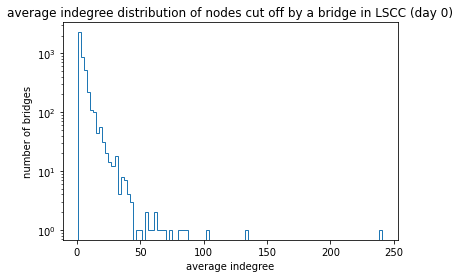

In [43]:
plt.hist(s_avg_ind_list[0], bins=100, density=False, log=True, histtype="step")
plt.title("average indegree distribution of nodes cut off by a bridge in LSCC (day 0)")
plt.ylabel('number of bridges')
plt.xlabel('average indegree')
plt.show();
    

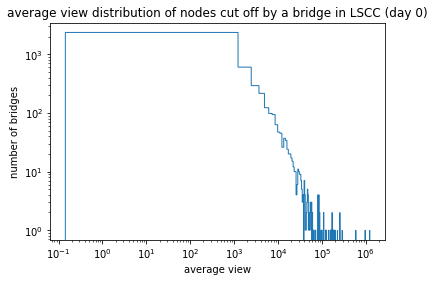

In [53]:
plt.hist(s_avg_view_list[0], bins=1000, density=False, log=True, histtype="step")
plt.title("average view distribution of nodes cut off by a bridge in LSCC (day 0)")
plt.ylabel('number of bridges')
plt.xlabel('average view')
plt.xscale('log')
plt.show();
    

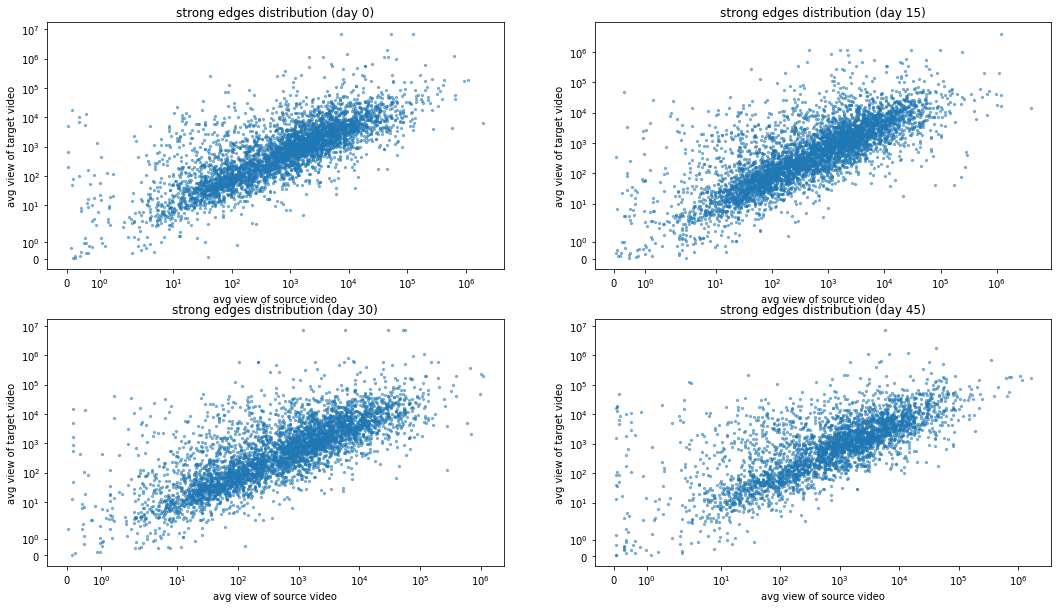

In [56]:
plt.figure(figsize=(18,10))
candidates = [0, 15, 30, 45]
for i, c in enumerate(candidates):
    plt.subplot(2,2,i+1)
    src_view = [embed_avg_view_dict[e[0]] for e in se_list[c]]
    tgt_view = [embed_avg_view_dict[e[1]] for e in se_list[c]]
    plt.scatter(src_view, tgt_view, s=5, marker='o', alpha=0.5)
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.title("strong edges distribution (day {0})".format((c)))
    plt.xlabel("avg view of source video")
    plt.ylabel("avg view of target video")

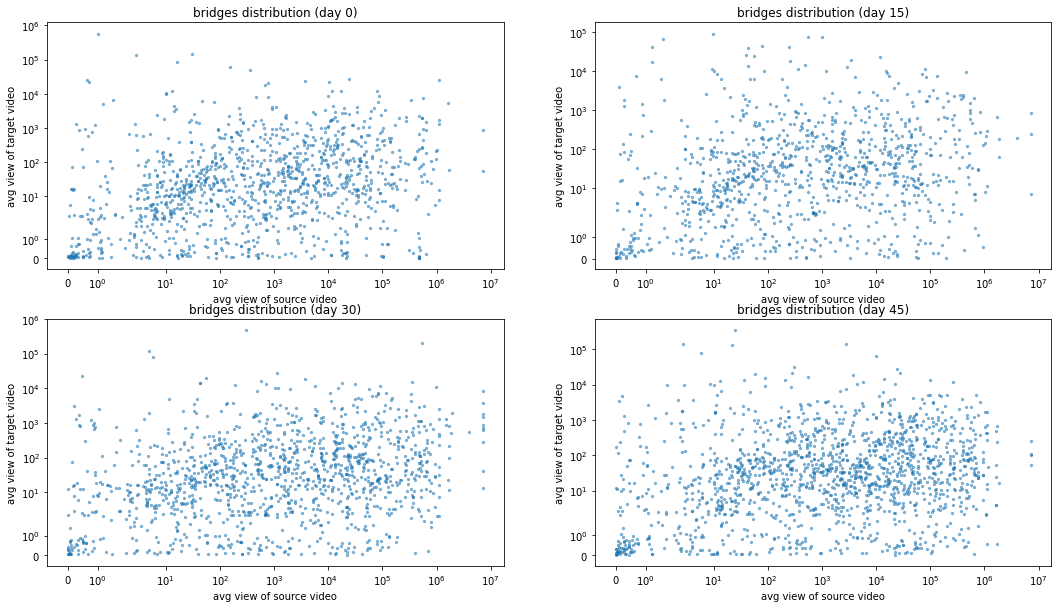

In [64]:
plt.figure(figsize=(18,10))
candidates = [0, 15, 30, 45]
for i, c in enumerate(candidates):
    plt.subplot(2,2,i+1)
    src_view = [embed_avg_view_dict[e[0]] for e in bridge_list[c]]
    tgt_view = [embed_avg_view_dict[e[1]] for e in bridge_list[c]]
    plt.scatter(src_view, tgt_view, s=5, marker='o', alpha=0.5)
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.title("bridges distribution (day {0})".format((c)))
    plt.xlabel("avg view of source video")
    plt.ylabel("avg view of target video")

In [58]:
len(src_view_small)

53

In [59]:
avg_view_small = [i for i in embed_avg_view_dict.values() if i < 1]

In [60]:
len(avg_view_small)

4186